# Explore: DUC Analytica Data

**GOAL:**
Analyze the data
1. Summarize the Data by looking at the data structure and the data distributions
2. Vizualize the data by looking at the attribute histograms and pairwise scatterplots of different attributes

## Imports
Import the necessary packages and their use cases for this project:

> pandas: data frames and data manipulation  
> numpy: summary statistics  
> matplotlib: used for visualizations  
> seasborn: fancy visualizations    
> pprint: Provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data
import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys # used in command to make entire array print by default

# import explore
from explore import df_summary
from explore import xgb_rank

# Feature Selection
# import xgboost as xgb
# from sklearn.decomposition import PCA

In [2]:
'''
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
'''

'\n%%javascript\nIPython.OutputArea.prototype._should_scroll = function(lines) {\n    return false;\n}\n'

In [3]:
# makes entire array print by default, 
# can add [:##] to end to set length
np.set_printoptions(threshold=sys.maxsize)

In [4]:
df = acquire_oil()
df = prep_data(df)

# Summarize Data

In [5]:
df_summary(df)

--- Shape: (7888, 58)
--- Info
<class 'pandas.core.frame.DataFrame'>
Index: 7888 entries, 30 to 17155
Data columns (total 58 columns):
api14                      7888 non-null int64
lease_name                 7888 non-null object
well_number                7888 non-null object
county                     7888 non-null object
direction                  7888 non-null category
status                     7888 non-null category
oper                       7888 non-null object
multi_well_lease           7888 non-null bool
major_phase                7888 non-null category
formation                  7888 non-null object
proppant_ppf               7888 non-null float64
prod_method                7888 non-null category
frac_fluid_gpf             7888 non-null float64
gross_perfs                7888 non-null float64
frac_stages                7888 non-null float64
frac_fluid_type            7888 non-null category
first_prod                 7888 non-null datetime64[ns]
last_prod                  788

api14                      7873
lease_name                 3543
well_number                3183
county                       38
direction                     2
status                        2
oper                        265
multi_well_lease              2
major_phase                   3
formation                    39
proppant_ppf               7785
prod_method                   9
frac_fluid_gpf             7818
gross_perfs                4468
frac_stages                  63
frac_fluid_type               9
first_prod                  413
last_prod                   289
peak_boepd                 7693
oil_hist                   7773
gas_hist                   7769
gor_hist                   7879
ip90_boeqpd                7775
tvd                        3952
sur_lat                    7682
sur_long                   7835
well_id                    7881
mid_point_lat              7868
mid_point_long             7872
sub_basin                     3
recovery                   7874
recovery

### Data Information

In [6]:
df.describe()

,api14,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,peak_boepd,oil_hist,gas_hist,gor_hist,ip90_boeqpd,...,scaled_lateral_class,scaled_proppant_ppf,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage
count,7.888000e+03,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,...,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000
mean,4.219613e+13,1129.177020,1142.213462,5732.858773,3.204488,508.725133,120.070635,385.288562,3888.944514,349.246186,...,0.402734,0.284274,0.380934,0.421953,0.045778,0.194749,0.520577,0.393372,0.647040,0.895554
std,1.047472e+12,656.539972,714.303891,2945.296014,9.336062,443.645469,95.660116,387.207769,3815.982884,315.135247,...,0.224940,0.165447,0.238298,0.216933,0.133372,0.191106,0.254807,0.145262,0.208235,0.136712
min,3.000528e+13,1.098097,0.354610,4.000000,0.000000,0.663017,0.031000,0.001000,0.212134,0.001812,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.217337e+13,525.892109,499.423181,4056.250000,0.000000,159.810463,46.481500,110.739000,1422.937793,94.906605,...,0.307692,0.132247,0.166494,0.298464,0.000000,0.071251,0.462055,0.280652,0.579955,0.900000
50%,4.231739e+13,1156.356260,1222.371400,6242.000000,0.000000,429.084519,101.236000,284.305000,2491.502805,292.328796,...,0.461538,0.291123,0.407675,0.459453,0.000000,0.124765,0.589809,0.383685,0.696075,0.933333
75%,4.238338e+13,1594.793975,1653.074860,7723.250000,0.000000,732.588900,172.310750,542.369000,4906.603828,508.700090,...,0.538462,0.401608,0.551362,0.568553,0.000000,0.245714,0.693837,0.478842,0.797456,0.950000
max,4.250137e+13,3969.384520,2997.879640,13581.000000,70.000000,6118.757000,754.662000,4007.768000,19968.130000,4752.926000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Visualize Data: Hypothesis Visualization

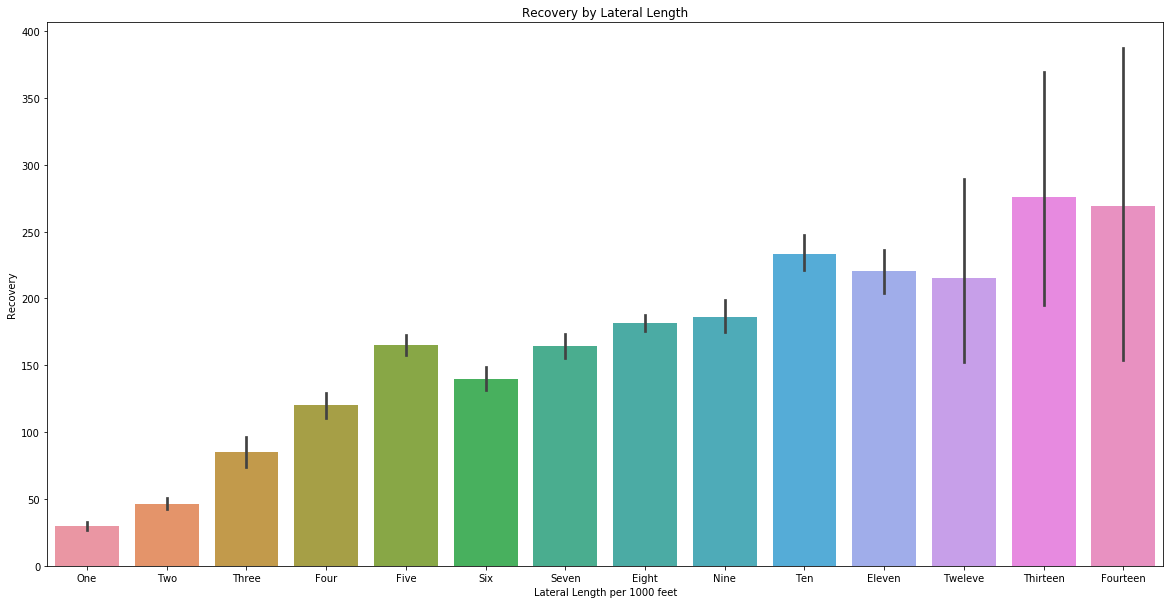

In [7]:
plt.figure(figsize=(20,10))
sns.barplot(x= df.lateral_class.sort_values(), y='recovery', data=df)

group_labels = ['One', 'Two', 'Three', 'Four', 'Five',
        'Six', 'Seven', 'Eight', 'Nine', 'Ten',
        'Eleven', 'Tweleve', 'Thirteen', 'Fourteen']

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], group_labels)

plt.title('Recovery by Lateral Length')
plt.xlabel('Lateral Length per 1000 feet')
plt.ylabel('Recovery')

plt.show()

#### Call xgb_rank to create the feature_list, scaled_features list, and the importance_df.

In [8]:
feature_list, scaled_features, importance_df = xgb_rank(df,df.recovery,feature_percent=80,mode='gain')

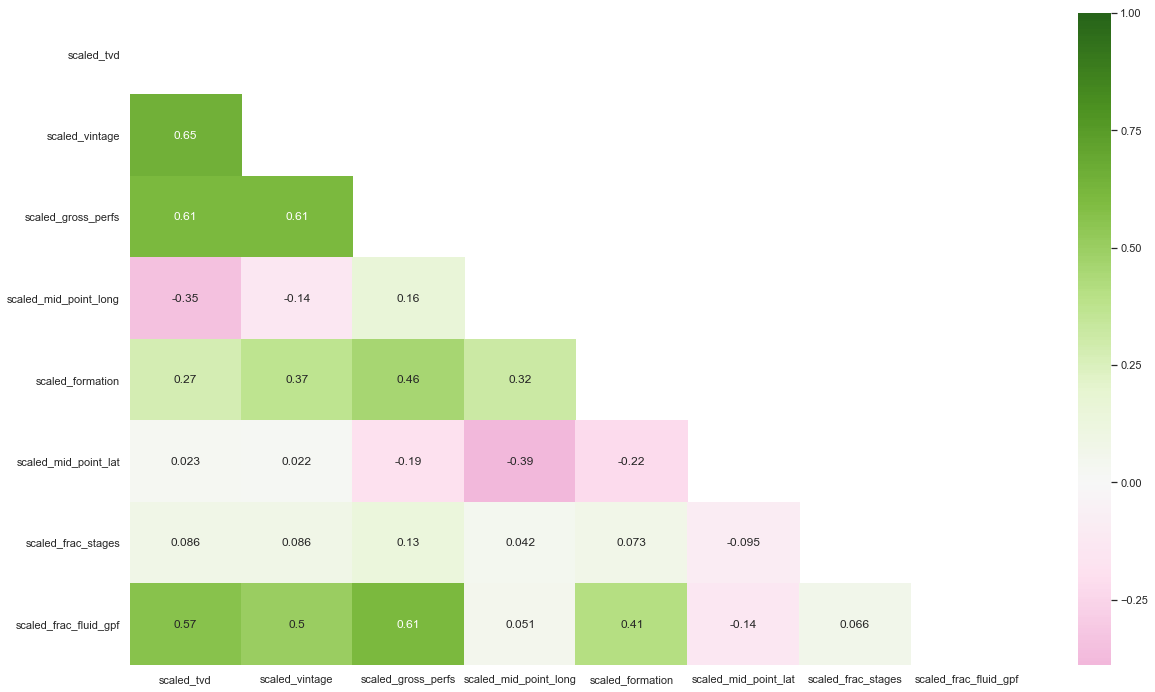

In [9]:
sns.set(style="white")

# Compute the correlation matrix
corr = df[scaled_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap='PiYG', annot=True, center=0)

### Attribute Histograms

In [10]:
feature_list

['tvd',
 'vintage',
 'gross_perfs',
 'mid_point_long',
 'formation',
 'mid_point_lat',
 'frac_stages',
 'frac_fluid_gpf']

#### Manually adjust list as necessary to encode features.

In [11]:
plot_list = ['tvd', 'vintage', 'gross_perfs', 'mid_point_long', 'mid_point_lat', 'encoded_formation', 'encoded_direction']

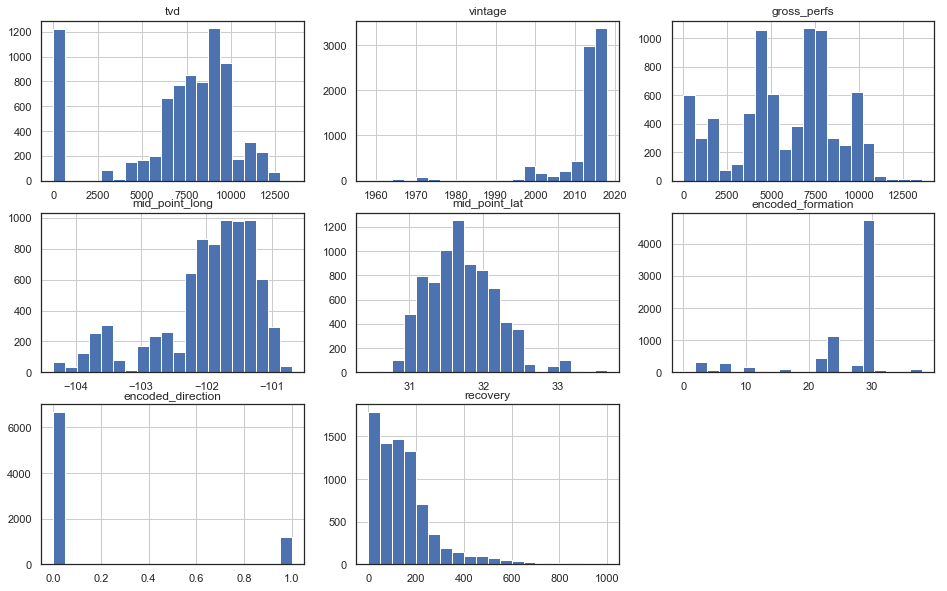

In [12]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(plot_list[:7]+['recovery']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]  
    plt.subplot(3, 3, plot_number)
    plt.title(col)
    series.hist(bins=20)

### Pairwise Scatterplots

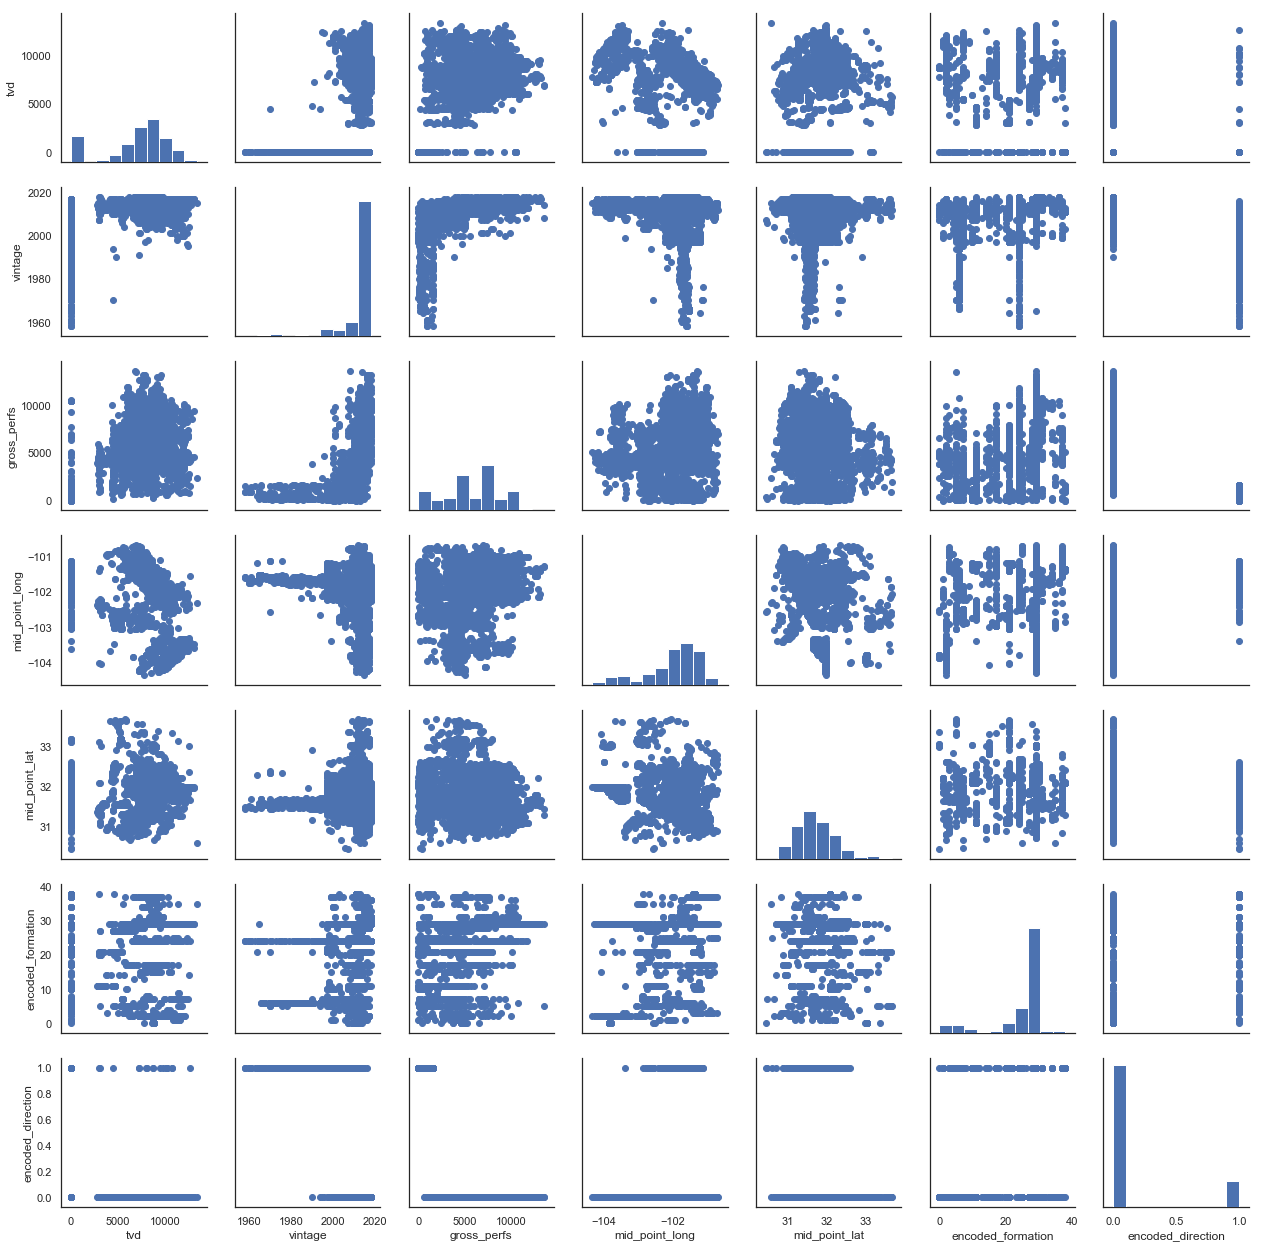

In [13]:
g = sns.PairGrid(df, vars=plot_list)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)